In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Introduction

This notebook explains how I analysed the hand flapping data to extract parameters on handflapping episodes, accelerometer magnitude, and FFT amplitude for data simulation.

# Import data

In [2]:
# Import Fourier Transform Results on handflapping data
df_handflapping_fft_results = pd.read_csv('data/fourier_transform/handflapping-fft-results.csv')
df_handflapping_fft_results.head()

,Frequency_Hz,Amplitude,Window,file_name
0,0.0,51.388647,0,handflapping-20240913-16h32.csv
1,1.0,0.345220,0,handflapping-20240913-16h32.csv
2,2.0,0.377005,0,handflapping-20240913-16h32.csv
3,3.0,0.549024,0,handflapping-20240913-16h32.csv
4,4.0,0.334656,0,handflapping-20240913-16h32.csv


In [3]:
# Import merged handflapping data
df_handflapping_merged = pd.read_csv('data/fourier_transform/handflapping-processed-detected-data.csv')
df_handflapping_merged.head()

,timestamp,accel.x,accel.y,accel.z,accel.mag,file_name,detected,Window
0,1.726238e+12,-0.922607,0.633545,0.143066,1.128296,handflapping-20240913-16h32.csv,True,0.0
1,1.726238e+12,-0.966431,0.498169,0.109497,1.092772,handflapping-20240913-16h32.csv,True,0.0
2,1.726238e+12,-0.966431,0.498169,0.109497,1.092772,handflapping-20240913-16h32.csv,True,0.0
3,1.726238e+12,-0.966431,0.498169,0.109497,1.092772,handflapping-20240913-16h32.csv,True,0.0
4,1.726238e+12,-0.966431,0.498169,0.109497,1.092772,handflapping-20240913-16h32.csv,True,0.0


In [4]:
parameters = {}

In [5]:
print("Total recorded seconds:", len(df_handflapping_merged)/50)
print("Total seconds of handflapping:", sum(df_handflapping_merged['detected'] == True)/50)

Total recorded seconds: 12038.0
Total seconds of handflapping: 1832.0


# Data analysis on handflapping episodes

We first analyse the data to identify the parameters of hand flapping episodes. A handflipping episode is defined as consecutive seconds, during which hand flappings were detected in all 1-second segments. 

## Identify hand flapping episodes

In [6]:
# Create a new column to store the episode number
df_handflapping_merged['episode'] = np.repeat(np.nan, len(df_handflapping_merged))

In [7]:
# Initialize variables
n_episode = 0
last_row_detected = False
episode_durations = []
episode_duration = 0
last_row_filename = None

# Iterate over the rows to detect the episodes and mark episode number
for i, row in df_handflapping_merged.iterrows():
    detected = row['detected']
    current_filename = row['file_name']
    
    if detected:
        # If a new episode starts
        if (last_row_detected == False) or (last_row_filename != current_filename):
            if episode_duration > 0:
                print(f"Episode {n_episode} duration: {episode_duration / 50} seconds")
                episode_durations.append(episode_duration / 50)
            episode_duration = 0
            n_episode += 1

        episode_duration += 1
        df_handflapping_merged.loc[i, 'episode'] = n_episode
        
    last_row_filename = current_filename
    last_row_detected = detected

# Handle the last episode if it ends at the last row
if episode_duration > 0:
    print(f"Episode {n_episode} duration: {episode_duration / 50} seconds")
    episode_durations.append(episode_duration / 50)

Episode 1 duration: 2.0 seconds
Episode 2 duration: 3.0 seconds
Episode 3 duration: 3.0 seconds
Episode 4 duration: 1.0 seconds
Episode 5 duration: 3.0 seconds
Episode 6 duration: 2.0 seconds
Episode 7 duration: 3.0 seconds
Episode 8 duration: 4.0 seconds
Episode 9 duration: 5.0 seconds
Episode 10 duration: 3.0 seconds
Episode 11 duration: 2.0 seconds
Episode 12 duration: 3.0 seconds
Episode 13 duration: 5.0 seconds
Episode 14 duration: 1.0 seconds
Episode 15 duration: 1.0 seconds
Episode 16 duration: 16.0 seconds
Episode 17 duration: 2.0 seconds
Episode 18 duration: 7.0 seconds
Episode 19 duration: 4.0 seconds
Episode 20 duration: 3.0 seconds
Episode 21 duration: 8.0 seconds
Episode 22 duration: 3.0 seconds
Episode 23 duration: 3.0 seconds
Episode 24 duration: 2.0 seconds
Episode 25 duration: 2.0 seconds
Episode 26 duration: 5.0 seconds
Episode 27 duration: 3.0 seconds
Episode 28 duration: 4.0 seconds
Episode 29 duration: 7.0 seconds
Episode 30 duration: 6.0 seconds
Episode 31 duratio

## Data analysis on episode features

In [8]:
avg_episode_duration = sum(episode_durations) / n_episode
sum_episode_duration = sum(episode_durations)
total_recorded_seconds = len(df_handflapping_merged)/50
total_recorded_minutes = total_recorded_seconds / 60

print("Total number of episodes:", n_episode)
print("Total episode duration in seconds", sum_episode_duration)
print("Total recorded seconds:", total_recorded_seconds)

print("Average duration of episode:", avg_episode_duration)
print("Number of episodes per minute:", n_episode / total_recorded_minutes)


Total number of episodes: 414
Total episode duration in seconds 1832.0
Total recorded seconds: 12038.0
Average duration of episode: 4.42512077294686
Number of episodes per minute: 2.063465691975411


Calculate the feature for each csv file.

In [9]:
epsiode_distribution = []
sampling_rate = 50

for f in df_handflapping_merged['file_name'].unique():
    data = df_handflapping_merged[df_handflapping_merged['file_name'] == f]
    n_seconds = len(data) / sampling_rate
    n_minutes = n_seconds / 60
    n_episodes = data['episode'].dropna().nunique()
    epsiode_distribution.append({
        "file_name": f,
        "n_seconds": n_seconds,
        "n_minutes": n_minutes,
        "n_episodes": n_episodes,
        "n_episodes_per_minute": n_episodes / n_minutes   
    })

df_epsiode_distribution = pd.DataFrame(epsiode_distribution)
df_epsiode_distribution

,file_name,n_seconds,n_minutes,n_episodes,n_episodes_per_minute
0,handflapping-20240913-16h32.csv,765.0,12.750000,22,1.725490
1,handflapping-20240914-16h55.csv,892.0,14.866667,26,1.748879
2,handflapping-20240915-12h46.csv,1116.0,18.600000,33,1.774194
3,handflapping-20240915-16h37.csv,1113.0,18.550000,40,2.156334
4,handflapping-20240915-17h28.csv,1120.0,18.666667,47,2.517857
5,handflapping-20240913-17h02.csv,768.0,12.800000,31,2.421875
6,handflapping-20240913-14h45.csv,776.0,12.933333,25,1.932990
7,handflapping-20240914-18h34.csv,993.0,16.550000,30,1.812689
8,handflapping-20240915-15h27.csv,1180.0,19.666667,49,2.491525
9,handflapping-20240914-16h15.csv,892.0,14.866667,26,1.748879


### Average number of episodes per minute

array([[<Axes: title={'center': 'n_seconds'}>,
        <Axes: title={'center': 'n_minutes'}>],
       [<Axes: title={'center': 'n_episodes'}>,
        <Axes: title={'center': 'n_episodes_per_minute'}>]], dtype=object)

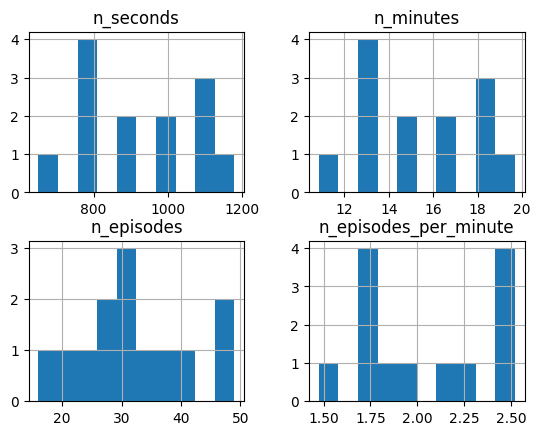

In [10]:
df_epsiode_distribution.iloc[:, 1:].hist()

In [11]:
epsiode_distribution_stats = df_epsiode_distribution.iloc[:, 1:].describe()
epsiode_distribution_stats

,n_seconds,n_minutes,n_episodes,n_episodes_per_minute
count,13.000000,13.000000,13.000000,13.000000
mean,926.000000,15.433333,31.846154,2.038628
std,171.622163,2.860369,9.511801,0.356499
min,651.000000,10.850000,16.000000,1.474654
25%,776.000000,12.933333,26.000000,1.748879
50%,892.000000,14.866667,31.000000,1.932990
75%,1113.000000,18.550000,37.000000,2.421875
max,1180.000000,19.666667,49.000000,2.517857


In [12]:
parameters['n_episode_per_minute_mean'] = epsiode_distribution_stats.loc['mean', 'n_episodes_per_minute']
parameters['n_episode_per_minute_mean']

np.float64(2.038628089855628)

In [13]:
parameters['n_episode_per_minute_std'] = epsiode_distribution_stats.loc['std', 'n_episodes_per_minute']
parameters['n_episode_per_minute_std']

np.float64(0.356499312978352)

### Episode duration: mean & std

<Axes: >

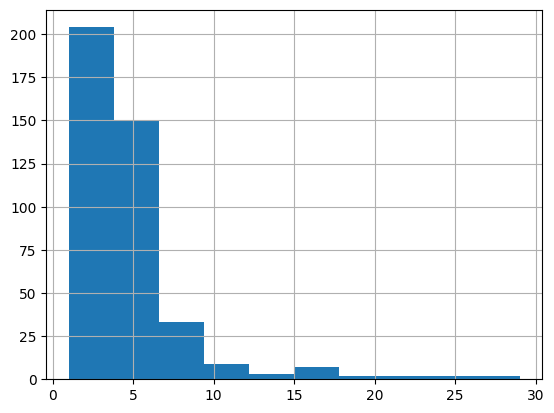

In [14]:
episode_durations_series = pd.Series(episode_durations)
episode_durations_series.hist()

Data is skewed, so apply log transform

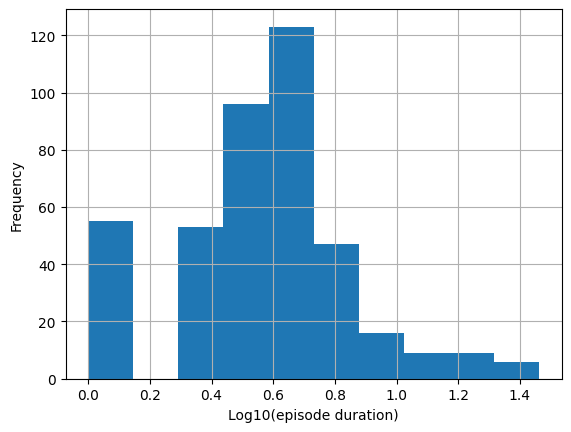

In [15]:
log_episode_durations = np.log10(episode_durations_series[episode_durations_series > 0])

# Plot the histogram of the log-transformed data
log_episode_durations.hist()
plt.xlabel('Log10(episode duration)')
plt.ylabel('Frequency')
plt.show()

Store parameters

In [16]:
print("Mean of episode duration (log10)", log_episode_durations.mean())
print("SD of episode duration (log10)", log_episode_durations.std())

parameters['episode_duration_log10_mean'] = log_episode_durations.mean()
parameters['episode_duration_log10_std'] = log_episode_durations.std()

Mean of episode duration (log10) 0.536328637127565
SD of episode duration (log10) 0.30279129334520477


## Export episode parameters

In [17]:
# Convert and write JSON object to file
with open("data/parameters/handflapping_episode_parameters.json", "w") as outfile: 
    json.dump(parameters, outfile)

# Data analysis on accelerometer magnitude

In [18]:
df_handflapping_merged.head()

,timestamp,accel.x,accel.y,accel.z,accel.mag,file_name,detected,Window,episode
0,1.726238e+12,-0.922607,0.633545,0.143066,1.128296,handflapping-20240913-16h32.csv,True,0.0,1.0
1,1.726238e+12,-0.966431,0.498169,0.109497,1.092772,handflapping-20240913-16h32.csv,True,0.0,1.0
2,1.726238e+12,-0.966431,0.498169,0.109497,1.092772,handflapping-20240913-16h32.csv,True,0.0,1.0
3,1.726238e+12,-0.966431,0.498169,0.109497,1.092772,handflapping-20240913-16h32.csv,True,0.0,1.0
4,1.726238e+12,-0.966431,0.498169,0.109497,1.092772,handflapping-20240913-16h32.csv,True,0.0,1.0


In [19]:
n_episode = df_handflapping_merged['episode'].max().astype(int)

# Range of values within episodes
accel_mag_ranges = []


for i in range(1, n_episode+1):
    df_episode = df_handflapping_merged[df_handflapping_merged['episode'] == i]
    range_dict = {
        'episode': i,
        'mean_accel_mag': np.mean(df_episode['accel.mag']),
        'min_accel_mag': min(df_episode['accel.mag']),
        'max_accel_mag': max(df_episode['accel.mag']),
        'range_accel_mag': max(df_episode['accel.mag']) - min(df_episode['accel.mag'])
    }

    accel_mag_ranges.append(range_dict)

In [20]:
accel_mag_ranges_df = pd.DataFrame(accel_mag_ranges)
accel_mag_ranges_df

,episode,mean_accel_mag,min_accel_mag,max_accel_mag,range_accel_mag
0,1,1.028029,0.992756,1.128296,0.135540
1,2,1.198384,0.995408,1.853208,0.857801
2,3,1.111010,1.003639,1.720741,0.717103
3,4,1.257055,0.877322,1.488166,0.610844
4,5,0.937573,0.228708,1.657965,1.429258
...,...,...,...,...,...
409,410,1.203092,0.603126,2.417969,1.814843
410,411,1.108921,0.718494,1.680508,0.962014
411,412,1.323223,0.583788,2.431368,1.847580
412,413,1.028011,0.577299,1.471752,0.894453


In [21]:
accel_mag_ranges_df['mean_to_min_accel_mag'] = accel_mag_ranges_df['mean_accel_mag'] - accel_mag_ranges_df['min_accel_mag']
accel_mag_ranges_df['max_to_mean_accel_mag'] = accel_mag_ranges_df['max_accel_mag'] - accel_mag_ranges_df['mean_accel_mag']
accel_mag_ranges_df.iloc[:, -2:]

,mean_to_min_accel_mag,max_to_mean_accel_mag
0,0.035274,0.100267
1,0.202976,0.654825
2,0.107371,0.609731
3,0.379733,0.231111
4,0.708865,0.720392
...,...,...
409,0.599967,1.214876
410,0.390427,0.571587
411,0.739435,1.108145
412,0.450712,0.443741


In [22]:
accel_mag_ranges_df_stats = accel_mag_ranges_df.describe()
accel_mag_ranges_df_stats

,episode,mean_accel_mag,min_accel_mag,max_accel_mag,range_accel_mag,mean_to_min_accel_mag,max_to_mean_accel_mag
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,1.116460,0.750633,1.699940,0.949307,0.365827,0.583480
std,119.655756,0.115223,0.211575,0.503958,0.655506,0.263168,0.417462
min,1.000000,0.937573,0.144274,1.038431,0.028527,0.012935,0.014422
25%,104.250000,1.041017,0.624519,1.402649,0.541735,0.170903,0.321848
50%,207.500000,1.092263,0.773568,1.637651,0.856708,0.318108,0.534717
75%,310.750000,1.147639,0.944173,1.889215,1.265884,0.514216,0.749652
max,414.000000,1.787953,1.022939,3.717011,3.185450,1.317549,2.407127


Inspect distribution

array([[<Axes: title={'center': 'mean_accel_mag'}>,
        <Axes: title={'center': 'min_accel_mag'}>],
       [<Axes: title={'center': 'max_accel_mag'}>,
        <Axes: title={'center': 'range_accel_mag'}>],
       [<Axes: title={'center': 'mean_to_min_accel_mag'}>,
        <Axes: title={'center': 'max_to_mean_accel_mag'}>]], dtype=object)

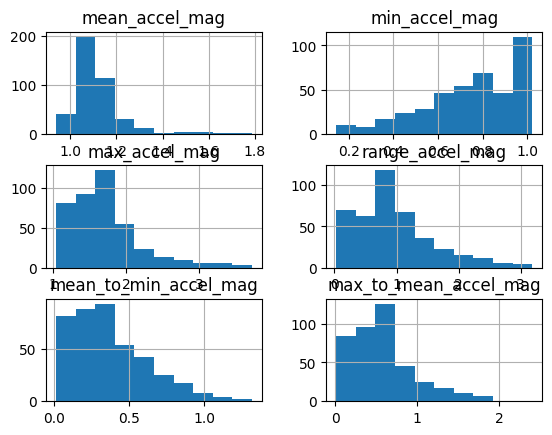

In [23]:
accel_mag_ranges_df.iloc[:, 1:].hist()

Log transform variables

In [24]:
accel_mag_ranges_df['mean_accel_mag_log10'] = np.log10(accel_mag_ranges_df['mean_accel_mag'])
accel_mag_ranges_df['min_accel_mag_log10'] = np.log10(accel_mag_ranges_df['min_accel_mag'])
accel_mag_ranges_df['max_accel_mag_log10'] = np.log10(accel_mag_ranges_df['max_accel_mag'])
accel_mag_ranges_df['range_accel_mag_log10'] = np.log10(accel_mag_ranges_df['range_accel_mag'])
accel_mag_ranges_df['mean_to_min_accel_mag_log10'] = np.log10(accel_mag_ranges_df['mean_to_min_accel_mag'])
accel_mag_ranges_df['max_to_mean_accel_mag_log10'] = np.log10(accel_mag_ranges_df['max_to_mean_accel_mag'])

In [25]:
accel_mag_ranges_df.iloc[:, -6:].describe()

,mean_accel_mag_log10,min_accel_mag_log10,max_accel_mag_log10,range_accel_mag_log10,mean_to_min_accel_mag_log10,max_to_mean_accel_mag_log10
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,0.045835,-0.147966,0.213300,-0.196443,-0.614975,-0.418810
std,0.040479,0.156720,0.120133,0.492488,0.482956,0.513978
min,-0.027995,-0.840811,0.016378,-1.544744,-1.888245,-1.840963
25%,0.017458,-0.204454,0.146949,-0.266214,-0.767250,-0.492350
50%,0.038327,-0.111502,0.214221,-0.067168,-0.497429,-0.271876
75%,0.059805,-0.024948,0.276281,0.102393,-0.288862,-0.125140
max,0.252356,0.009850,0.570194,0.503171,0.119767,0.381499


array([[<Axes: title={'center': 'mean_accel_mag_log10'}>,
        <Axes: title={'center': 'min_accel_mag_log10'}>],
       [<Axes: title={'center': 'max_accel_mag_log10'}>,
        <Axes: title={'center': 'range_accel_mag_log10'}>],
       [<Axes: title={'center': 'mean_to_min_accel_mag_log10'}>,
        <Axes: title={'center': 'max_to_mean_accel_mag_log10'}>]],
      dtype=object)

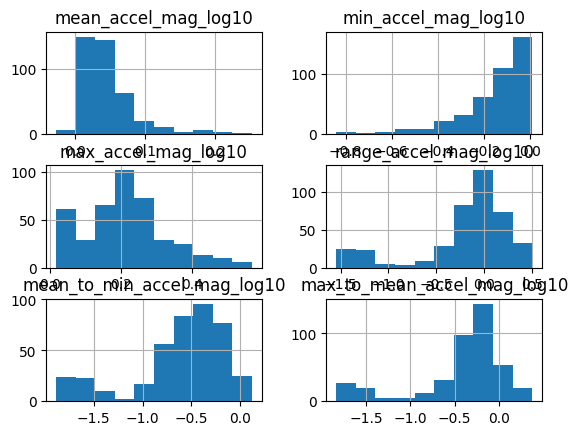

In [26]:
accel_mag_ranges_df.iloc[:, -6:].hist()

#### Export descriptive statistics on acceleration magnitudes

In [27]:
accel_mag_ranges_df.describe().to_csv('data/parameters/handflapping_accel_mag_parameters.csv', index=True)

# Data analysis on FFT frequency & amplitude

## Import data

In [28]:
df_handflapping_fft_results.head()

,Frequency_Hz,Amplitude,Window,file_name
0,0.0,51.388647,0,handflapping-20240913-16h32.csv
1,1.0,0.345220,0,handflapping-20240913-16h32.csv
2,2.0,0.377005,0,handflapping-20240913-16h32.csv
3,3.0,0.549024,0,handflapping-20240913-16h32.csv
4,4.0,0.334656,0,handflapping-20240913-16h32.csv


Join FFT results dataframe and the 'detected' column of handflapping dataframe

In [29]:
df_handflapping_fft_results = pd.merge(df_handflapping_fft_results,
         df_handflapping_merged[['detected', 'file_name', 'Window']].drop_duplicates(),
         on=['file_name', 'Window'],
         how='left')

In [30]:
df_handflapping_fft_results.head()

,Frequency_Hz,Amplitude,Window,file_name,detected
0,0.0,51.388647,0,handflapping-20240913-16h32.csv,True
1,1.0,0.345220,0,handflapping-20240913-16h32.csv,True
2,2.0,0.377005,0,handflapping-20240913-16h32.csv,True
3,3.0,0.549024,0,handflapping-20240913-16h32.csv,True
4,4.0,0.334656,0,handflapping-20240913-16h32.csv,True


## Inspect distribution of amplitudes

Inspect the distribution of amplitudes of 1-24 Hz bands. The amplitude 0 Hz is a constant, so it is ignored.

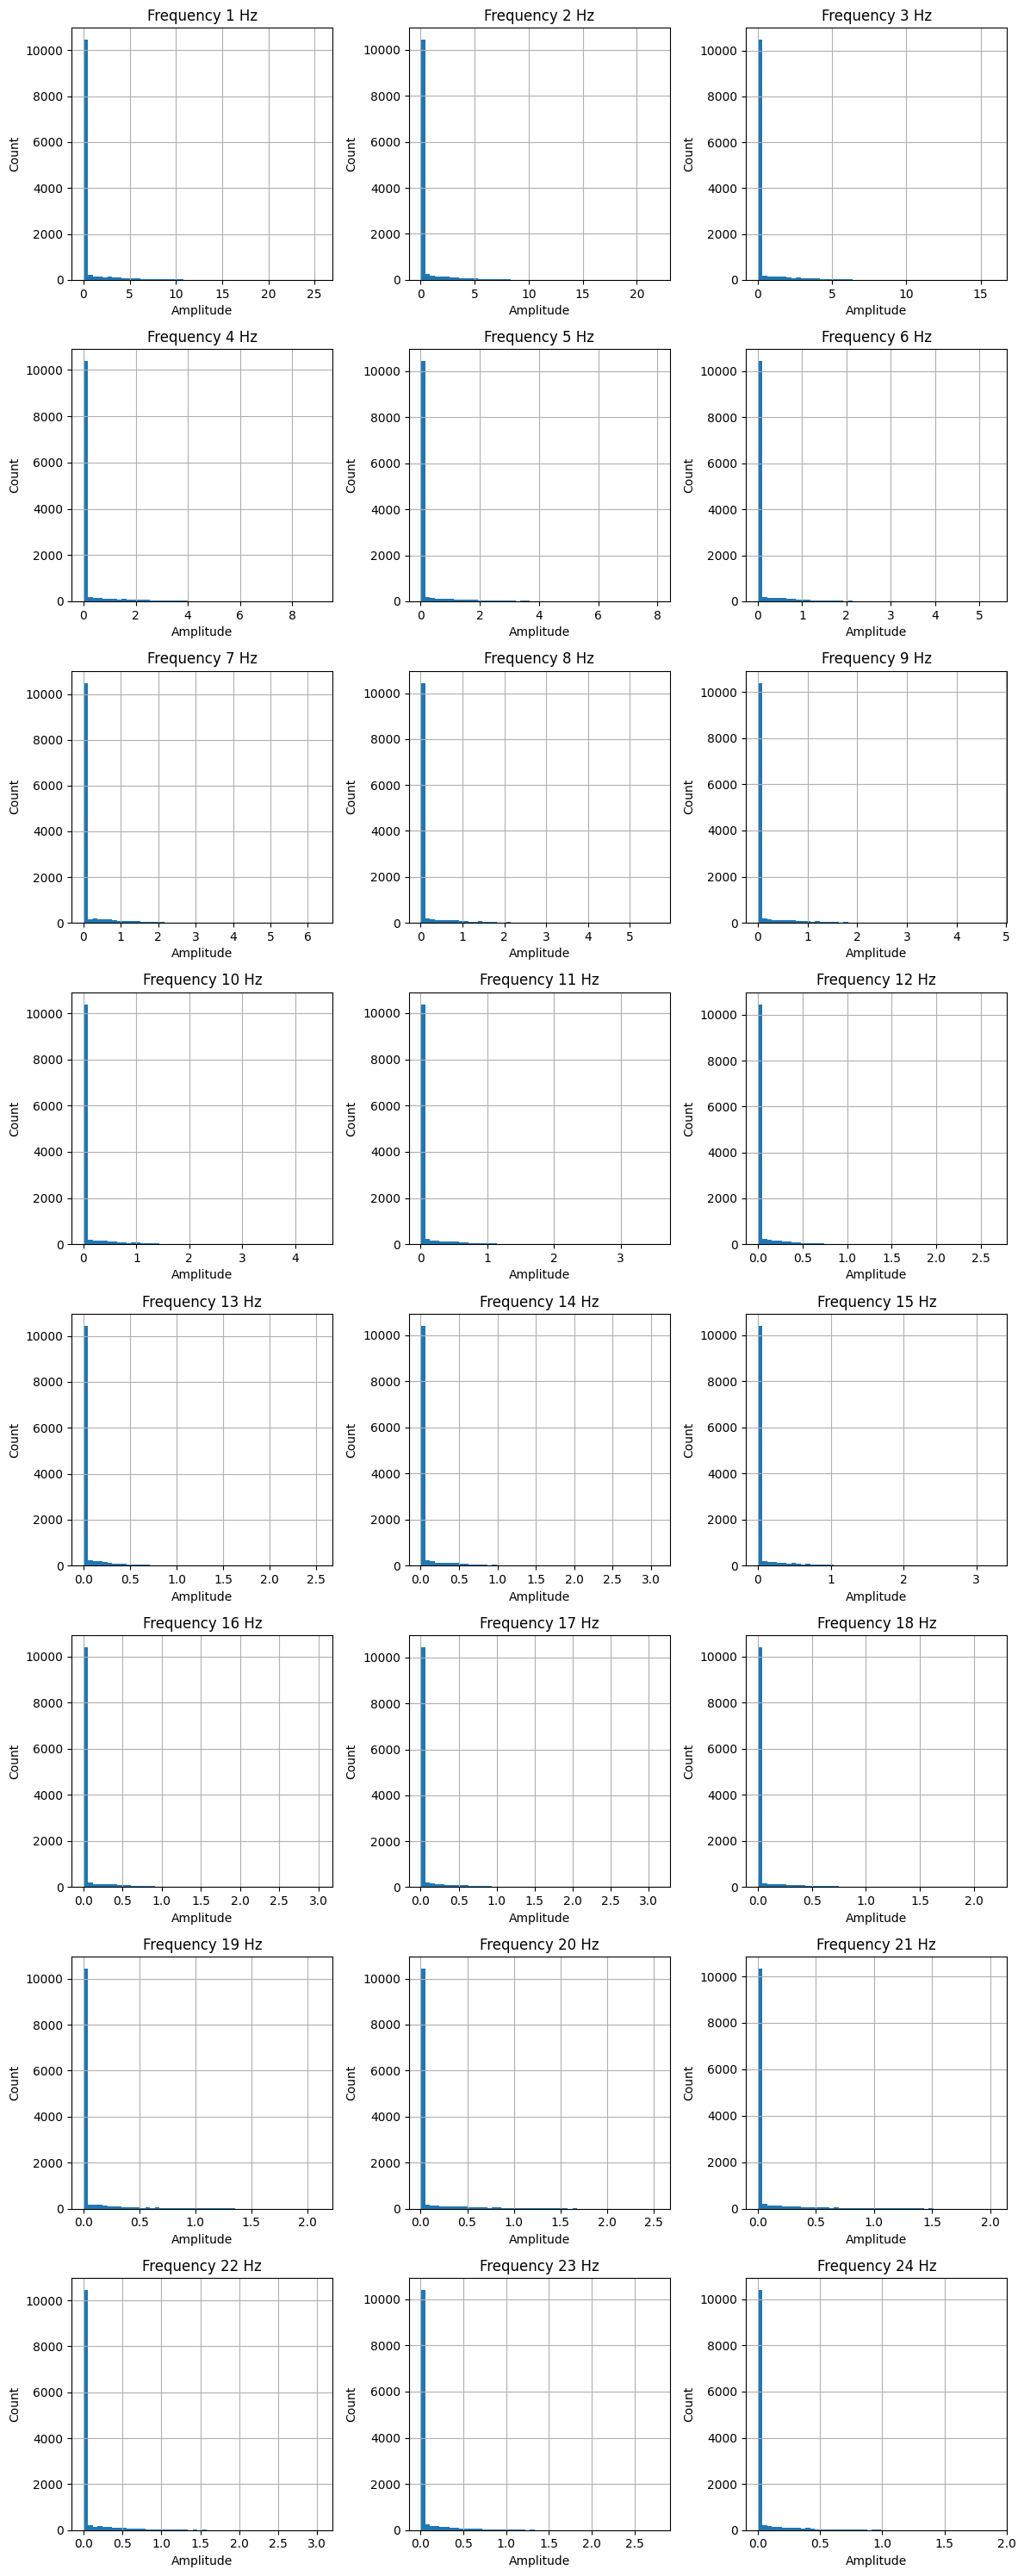

In [31]:
# Set up the figure and axes for subplots
fig, axes = plt.subplots(8, 3, figsize=(12, 30))  # 6 rows, 4 columns for 24 subplots
axes = axes.ravel()  # Flatten the 2D array of axes for easy iteration

# Plot each histogram in a subplot
for f in range(1, 25):
    ax = axes[f-1]
    df_handflapping_fft_results[df_handflapping_fft_results['Frequency_Hz'] == f]['Amplitude'].hist(
        bins=50, ax=ax
    )
    ax.set_title(f"Frequency {f} Hz")
    ax.set_xlabel("Amplitude")
    ax.set_ylabel("Count")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Log transform the amplitude

In [32]:
df_handflapping_fft_results['Amplitude_log10'] = np.log10(df_handflapping_fft_results['Amplitude'])   

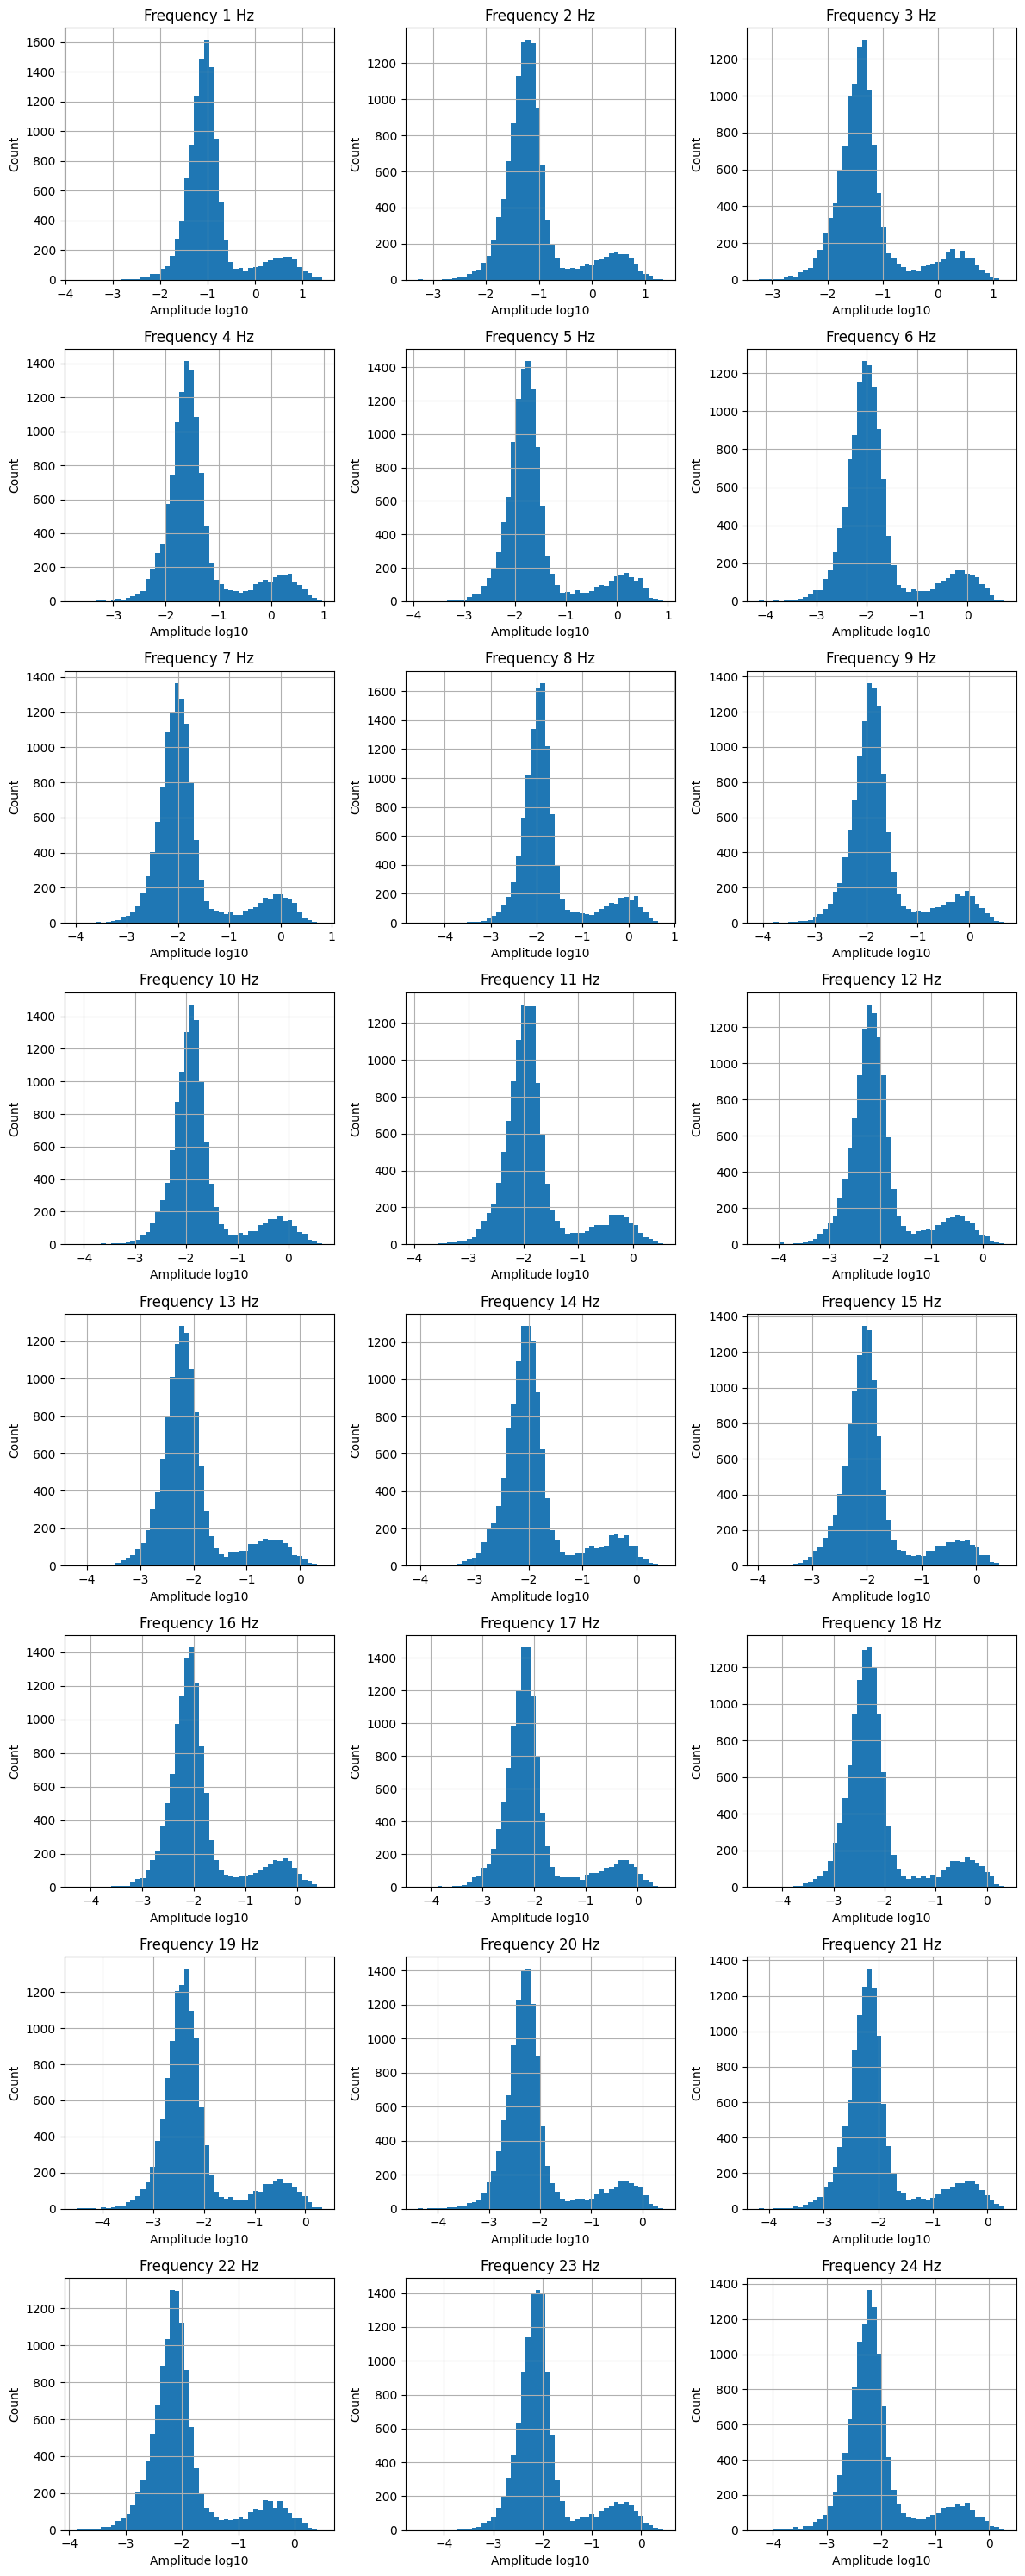

In [33]:
# Set up the figure and axes for subplots
fig, axes = plt.subplots(8, 3, figsize=(12, 30))  # 6 rows, 4 columns for 24 subplots
axes = axes.ravel()  # Flatten the 2D array of axes for easy iteration

# Plot each histogram in a subplot
for f in range(1, 25):
    ax = axes[f-1]
    df_handflapping_fft_results[df_handflapping_fft_results['Frequency_Hz'] == f]['Amplitude_log10'].hist(
        bins=50, ax=ax
    )
    ax.set_title(f"Frequency {f} Hz")
    ax.set_xlabel("Amplitude log10")
    ax.set_ylabel("Count")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

The distribution is bi-modal. The lower mode is probably the noise, hence redo the analysis on amplitude above noise threshold

## Inspect distribution of amplitudes above noise threshold 

In [34]:
df_baseline = pd.read_csv('./data/fourier_transform/standstill-fft-results.csv')
amplitude_noise_threshold = max(df_baseline[-24:]['max_amp'])
amplitude_noise_threshold

0.2962334067485641

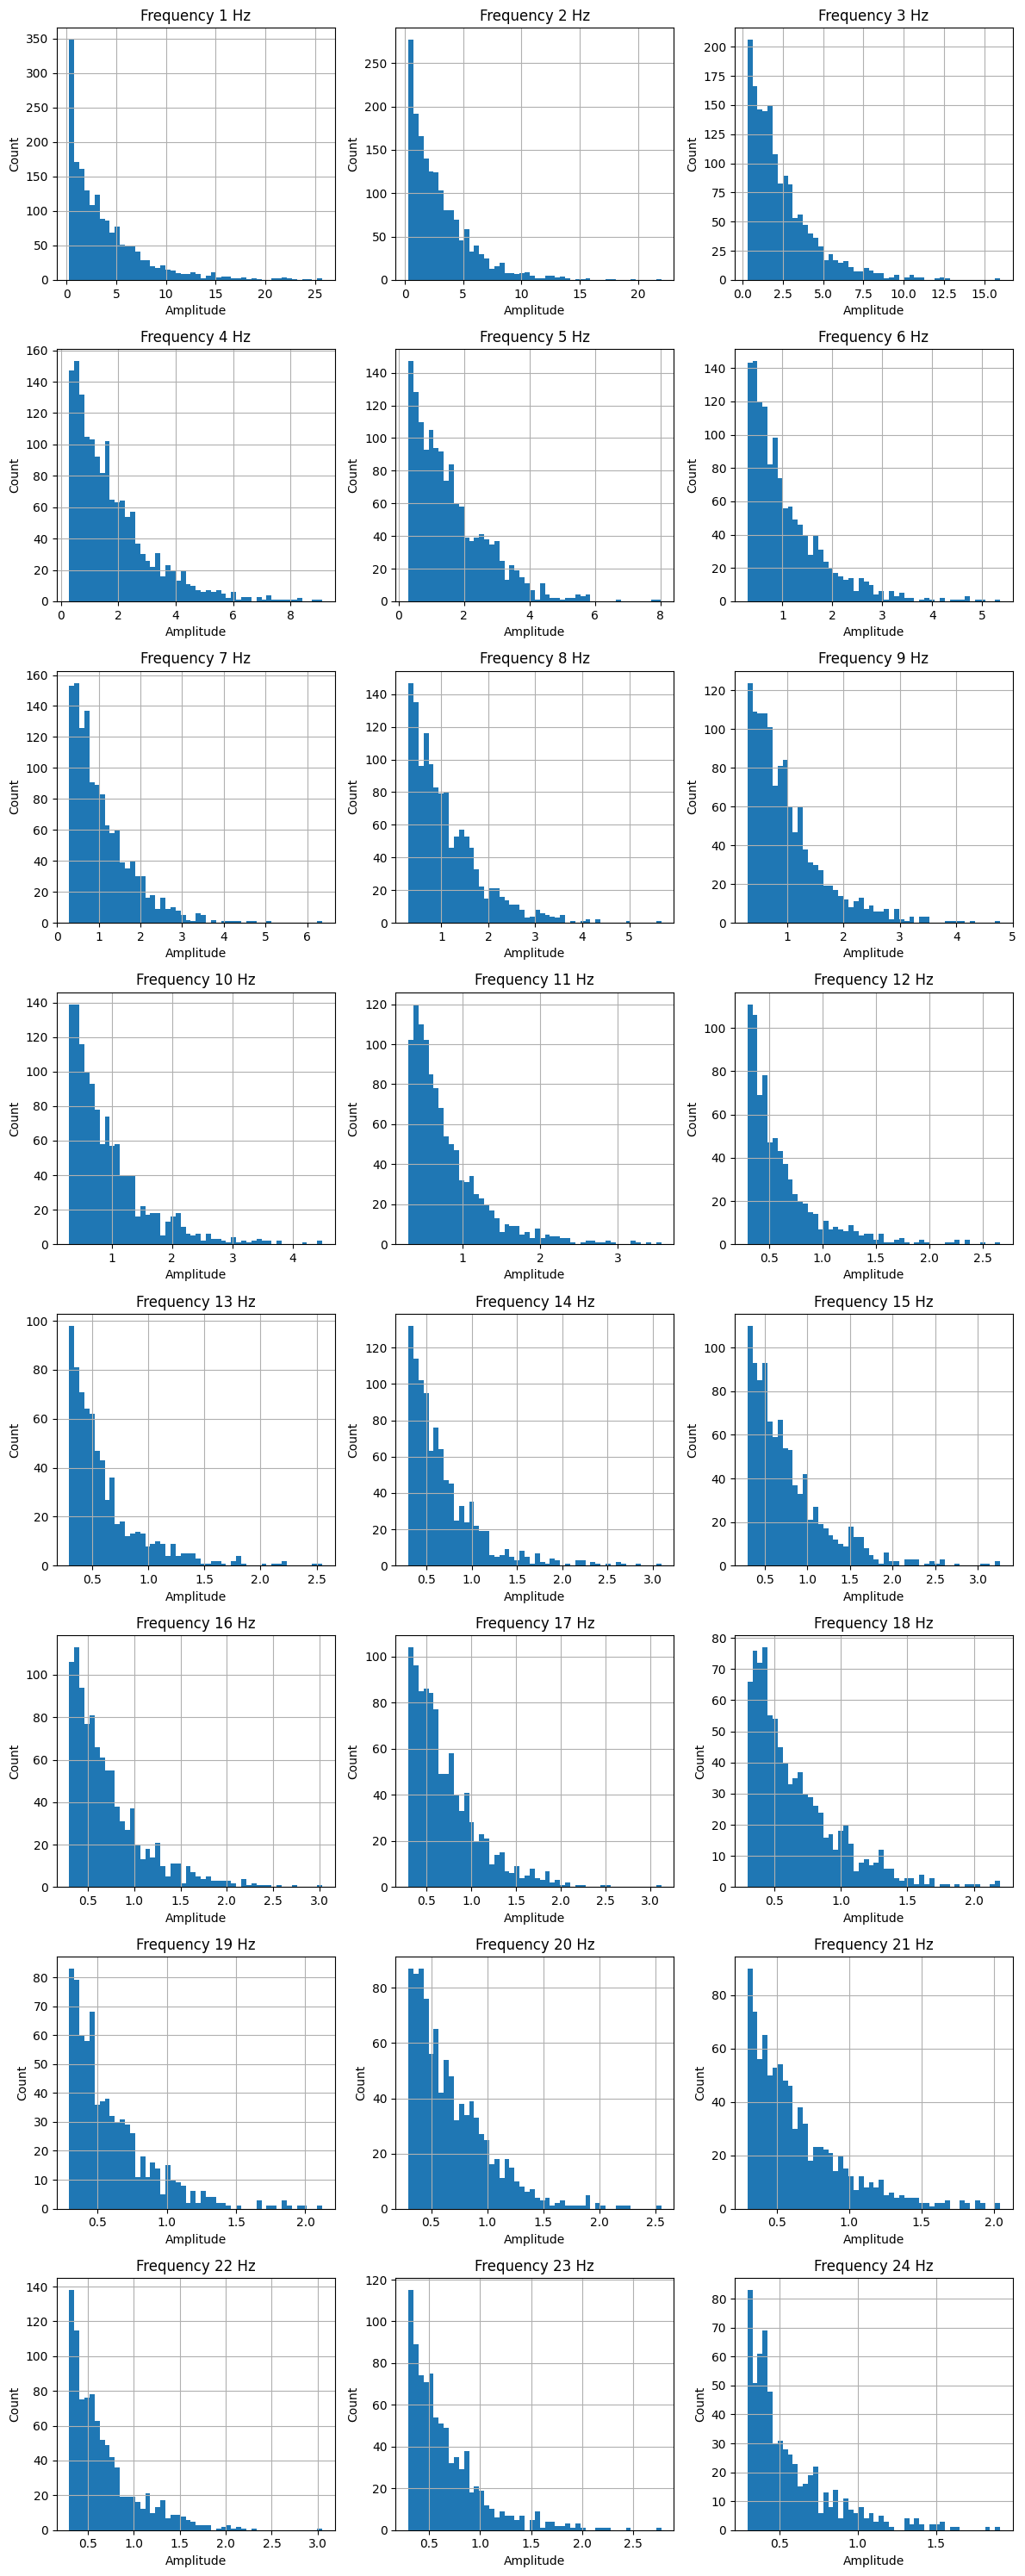

In [35]:
# Set up the figure and axes for subplots
fig, axes = plt.subplots(8, 3, figsize=(12, 30))  # 6 rows, 4 columns for 24 subplots
axes = axes.ravel()  # Flatten the 2D array of axes for easy iteration

# Plot each histogram in a subplot
for f in range(1, 25):
    ax = axes[f-1]

    data = df_handflapping_fft_results[df_handflapping_fft_results['Frequency_Hz'] == f]['Amplitude'] 
    data = data[data > amplitude_noise_threshold]

    data.hist(
        bins=50, ax=ax
    )

    ax.set_title(f"Frequency {f} Hz")
    ax.set_xlabel("Amplitude")
    ax.set_ylabel("Count")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Distribution is skewed, try log transform

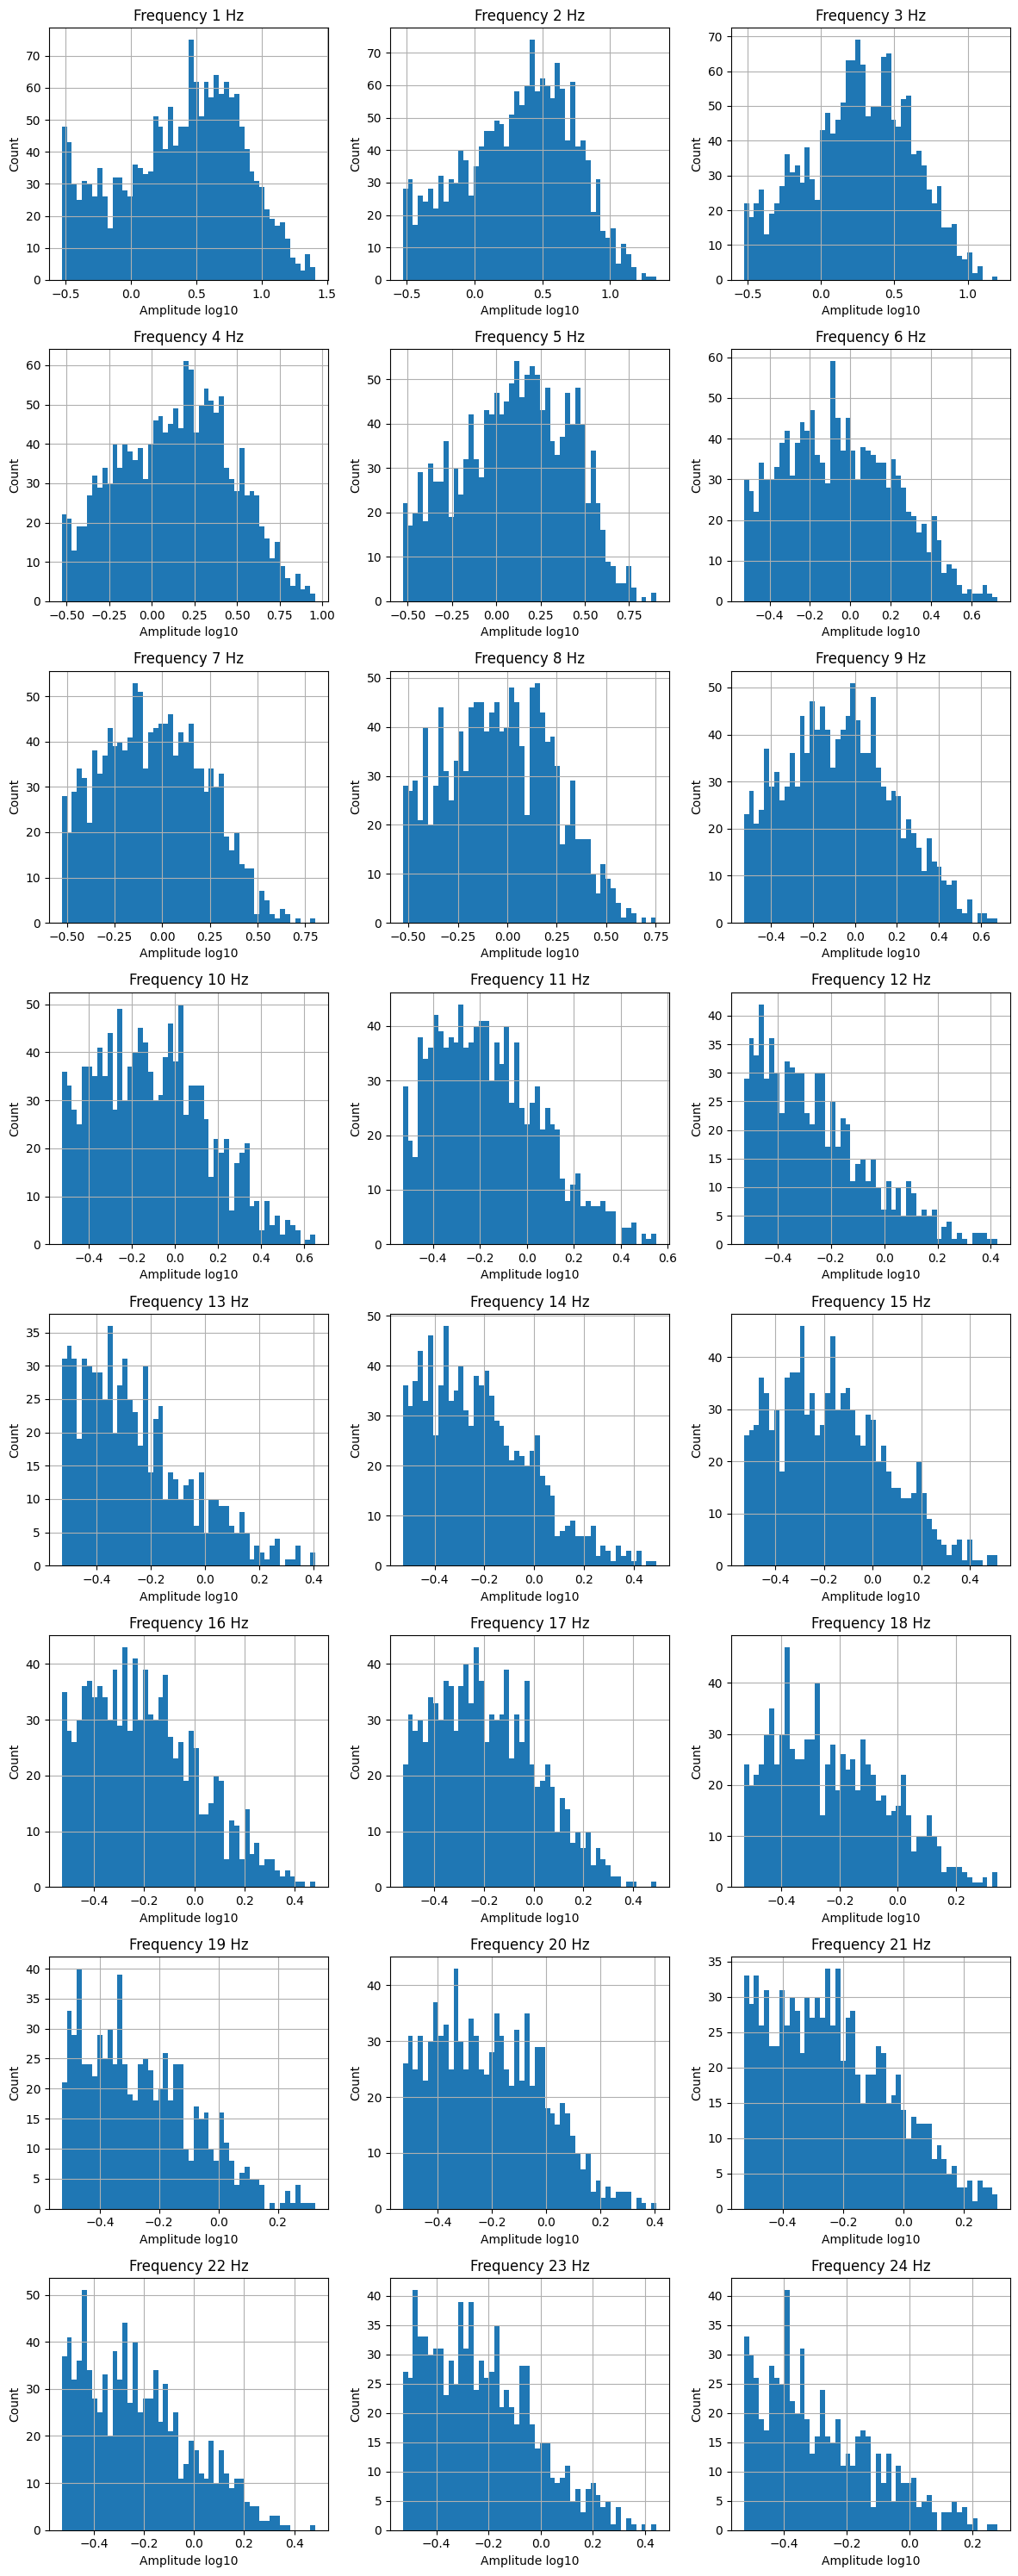

In [36]:
# Set up the figure and axes for subplots
fig, axes = plt.subplots(8, 3, figsize=(12, 30))  # 6 rows, 4 columns for 24 subplots
axes = axes.ravel()  # Flatten the 2D array of axes for easy iteration

# Plot each histogram in a subplot
for f in range(1, 25):
    ax = axes[f-1]

    data = df_handflapping_fft_results[df_handflapping_fft_results['Frequency_Hz'] == f]['Amplitude'] 
    data = data[data > amplitude_noise_threshold]
    data = np.log10(data)

    data.hist(
        bins=50, ax=ax
    )

    ax.set_title(f"Frequency {f} Hz")
    ax.set_xlabel("Amplitude log10")
    ax.set_ylabel("Count")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Calculate filtered amplitudes distribution statistics

In [37]:
frequncy_filtered_amp = []

for f in range(25):
    data = df_handflapping_fft_results[df_handflapping_fft_results['Frequency_Hz'] == f]['Amplitude'] 
    data = data[data > amplitude_noise_threshold]
    data = np.log10(data)
    frequncy_filtered_amp.append({
        'Frequency_Hz': f,
        'amp_log10_filtered_mean': data.mean(),
        'amp_log10_filtered_std': data.std(),
        'amp_log10_filtered_min': data.min(),
        'amp_log10_filtered_max': data.max()
    })

In [38]:
frequncy_filtered_amp_df = pd.DataFrame(frequncy_filtered_amp)
frequncy_filtered_amp_df

,Frequency_Hz,amp_log10_filtered_mean,amp_log10_filtered_std,amp_log10_filtered_min,amp_log10_filtered_max
0,0,1.713486,0.029071,1.502367,2.138384
1,1,0.375985,0.461004,-0.527929,1.409866
2,2,0.317702,0.401565,-0.528232,1.341908
3,3,0.249057,0.359702,-0.525814,1.203745
4,4,0.137923,0.327710,-0.528098,0.959313
5,5,0.100445,0.308168,-0.528341,0.904682
6,6,-0.052585,0.273730,-0.527648,0.729083
7,7,-0.042441,0.265555,-0.527100,0.803128
8,8,-0.038328,0.267764,-0.528115,0.754432
9,9,-0.071753,0.253134,-0.528310,0.679323


## Export statistics

In [39]:
frequncy_filtered_amp_df.to_csv('data/parameters/handflapping_fft_simulation_parameters.csv', index=False)